In [1]:
import os
import json
# change the default cache dir so that huggingface won't take the cse space.
os.environ['TRANSFORMERS_CACHE'] = '/export/scratch/zeren/KimNLP/HuggingfaceCache/'

import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
import torch
import argparse
from transformers import AutoModel, AutoTokenizer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

/export/scratch/Zeren/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)

Bad key "text.kerning_factor" on line 4 in
/export/scratch/Zeren/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def merge_annotations(x, y):
    if type(y) == str:
        return y.strip().lower()
    return x.strip().lower()

def dict_to_gpu(input_dict):
    output_dict = {key: value.cuda() for key, value in input_dict.items()}
    return output_dict

In [3]:
def load_kim_dataset(data_filename = '/export/scratch/zeren/KimNLP/RawData/dec_12_annotations.tsv'):
    data = pd.read_csv(data_filename, sep='\t')

    data['annotation'] = data.apply(lambda x: merge_annotations(x['previous annotation'], x['new annotation']), axis=1)
    columns = ['cited title', 'cited abstract', 'citing title', 'citing abstract', 'citation context', 'annotation']
    data = data[columns]
    data = data.rename(columns={
        'cited title': 'cited_title', 
        'cited abstract': 'cited_abstract', 
        'citing title': 'citing_title', 
        'citing abstract': 'citing_abstract', 
        'citation context': 'citation_context', 
        'annotation': 'label'
    }).reset_index().drop(columns='index')
    data = data.fillna('')
    data.head()
    return data

def load_acl_scicite_dataset(data_dir, data_name):
    train_data_filename = os.path.join(
        data_dir, '{}_train_with_abstracts.jsonl'.format(data_name)
    )
    test_data_filename = os.path.join(
        data_dir, '{}_test_with_abstracts.jsonl'.format(data_name)
    )

    with open(train_data_filename, 'r') as train_f:
        train_list = train_f.readlines()
    
    with open(test_data_filename, 'r') as test_f:
        test_list = test_f.readlines()
    
    train_data = []
    test_data = []
    for json_str in train_list:
        json_dict = json.loads(json_str)
        train_data.append(json_dict)
    
    for json_str in test_list:
        json_dict = json.loads(json_str)
        test_data.append(json_dict)

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    train_df = train_df.fillna('')
    test_df = test_df.fillna('')

    return train_df, test_df

In [4]:
# data = load_kim_dataset()
data, _ = load_acl_scicite_dataset('/export/scratch/zeren/KimNLP/RawData/datasets', 'acl_arc')

In [5]:
data.head(20)

,citing_abstract,citing_title,cited_abstract,cited_title,citation_context,label
0,We present a theoretical analysis of online pa...,a holistic lexiconbased approach to opinion mi...,"Often, the training procedure for statistical ...",minimum error rate training in statistical mac...,This was done by MERT optimization ( <CITED HE...,Uses
1,We present a methodology for extracting subcat...,a holistic lexiconbased approach to opinion mi...,We describe a novel technique and implemented ...,automatic extraction of subcategorization from...,<CITED HERE> report on manually analyzing an o...,CompareOrContrast
2,Two apparently opposing DOP models exist in th...,a holistic lexiconbased approach to opinion mi...,We present a new parser for parsing down to Pe...,a maximumentropyinspired parser,This is roughly an 11 % relative reduction in ...,CompareOrContrast
3,We explore the contribution of lexical and inf...,a holistic lexiconbased approach to opinion mi...,We present an enriched version of the Penn Ara...,a corpus for modeling morphosyntactic agreemen...,We use the agreement checker code developed by...,Uses
4,Instances of a word drawn from different domai...,a holistic lexiconbased approach to opinion mi...,"In this paper, we evaluate a variety of knowle...",an empirical evaluation of knowledge sources a...,"Similar to our previous work ( Chan and Ng , 2...",Uses
5,"In this paper, we focus on the problem of usin...",a holistic lexiconbased approach to opinion mi...,Joint compression and summarization has been u...,document summarization via guided sentence com...,"Similar to ( <CITED HERE>a ) , our summarizati...",CompareOrContrast
6,We present an online learning algorithm for tr...,a holistic lexiconbased approach to opinion mi...,Parsing algorithms that process the input from...,algorithms for deterministic incremental depen...,transition-based dependency parsing framework ...,Uses
7,Word-level alignment of bilingual text is a cr...,a holistic lexiconbased approach to opinion mi...,Previous work has used monolingual parallel co...,paraphrasing with bilingual parallel corpora,But their importance has grown far beyond mach...,Motivation
8,Two apparently opposing DOP models exist in th...,a holistic lexiconbased approach to opinion mi...,This paper introduces new learning algorithms ...,new ranking algorithms for parsing and tagging...,<CITED HERE> showed how the perceptron algorit...,Background
9,"In current research, most tree-based translati...",a holistic lexiconbased approach to opinion mi...,In this work we propose methods to label proba...,a wordclass approach to labeling pscfg rules f...,"11 From ( <CITED HERE> ) , we find that the pe...",Motivation


In [6]:
model_name = 'allenai/scibert_scivocab_uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
bert_model = bert_model.cuda()
bert_model.eval()

cited_title_embs = []
cited_abstract_embs = []
citing_title_embs = []
citing_abstract_embs = []

with torch.no_grad():
    for idx in tqdm(range(data.shape[0])):
        cited_title_tokens = dict_to_gpu(bert_tokenizer(data['cited_title'].values[idx], return_tensors='pt', max_length=512, truncation=True))
        citing_title_tokens = dict_to_gpu(bert_tokenizer(data['citing_title'].values[idx], return_tensors='pt', max_length=512, truncation=True))
        cited_abstract_tokens = dict_to_gpu(bert_tokenizer(data['cited_abstract'].values[idx], return_tensors='pt', max_length=512, truncation=True))
        citing_abstract_tokens = dict_to_gpu(bert_tokenizer(data['citing_abstract'].values[idx], return_tensors='pt', max_length=512, truncation=True))

        cited_title_embs.append(bert_model(**cited_title_tokens))
        citing_title_embs.append(bert_model(**citing_title_tokens))
        cited_abstract_embs.append(bert_model(**cited_abstract_tokens))
        citing_abstract_embs.append(bert_model(**citing_abstract_tokens))

  0%|          | 0/571 [00:00<?, ?it/s]

In [8]:
cited_title_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in cited_title_embs]).cpu()
cited_abstract_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in cited_abstract_embs]).cpu()
citing_title_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in citing_title_embs]).cpu()
citing_abstract_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in citing_abstract_embs]).cpu()

In [9]:
title_diff = cited_title_embs - citing_title_embs
abstract_diff = cited_abstract_embs - citing_abstract_embs

In [10]:
title_diff_norm = (cited_title_embs - citing_title_embs).norm(dim=1).numpy()
abstract_diff_norm = (cited_abstract_embs - citing_abstract_embs).norm(dim=1).numpy()

In [11]:
categories, count = np.unique(data['label'].values, return_counts=True)
cate2id = {c:i for i, c in enumerate(categories)}
cate_colors = np.array([cate2id[c] for c in data['label'].values])
title_diff_norm_dict = {c: title_diff_norm[data['label'].values == c] for c in categories}
abstract_diff_norm_dict = {c: abstract_diff_norm[data['label'].values == c] for c in categories}

In [12]:
tsne_title_diff = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, random_state=42)
tsne_title_diff_results = tsne_title_diff.fit_transform(title_diff)

tsne_abstract_diff = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, random_state=42)
tsne_abstract_diff_results = tsne_abstract_diff.fit_transform(abstract_diff)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 571 samples in 0.011s...
[t-SNE] Computed neighbors for 571 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 571 / 571
[t-SNE] Mean sigma: 4.343462
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.020309
[t-SNE] KL divergence after 500 iterations: 0.970861
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 571 samples in 0.010s...
[t-SNE] Computed neighbors for 571 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 571 / 571
[t-SNE] Mean sigma: 2.584666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.740005
[t-SNE] KL divergence after 500 iterations: 0.930481


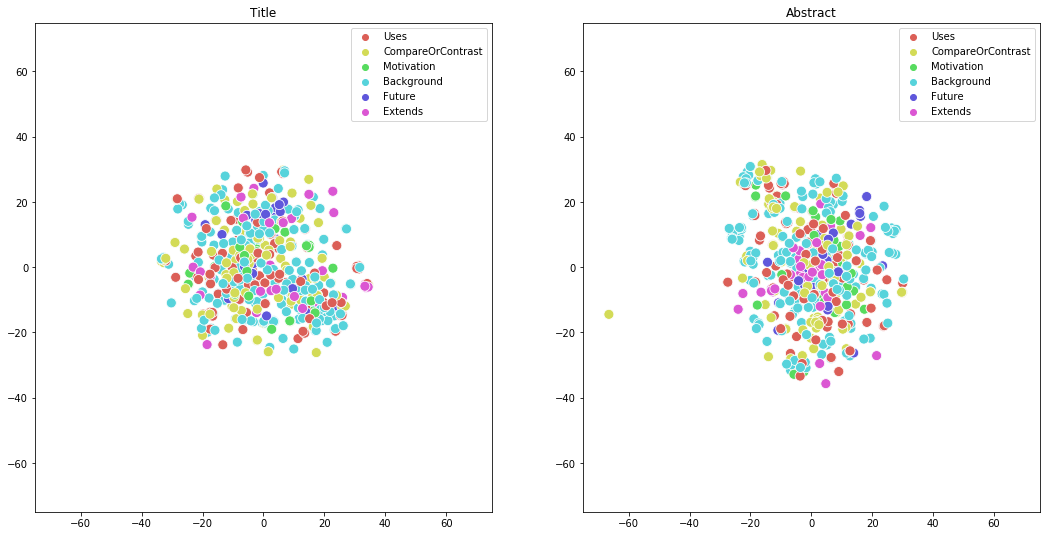

In [13]:
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.title('Title')
sns.scatterplot(
    x=tsne_title_diff_results[:, 0], y=tsne_title_diff_results[:, 1],
    hue=data['label'].values,
    palette=sns.color_palette("hls", len(np.unique(data['label'].values))),
    legend="full",
    alpha=1.,
    s=100
)
plt.xlim([-75, 75])
plt.ylim([-75, 75])

plt.subplot(1, 2, 2)
plt.title('Abstract')
sns.scatterplot(
    x=tsne_abstract_diff_results[:, 0], y=tsne_abstract_diff_results[:, 1],
    hue=data['label'].values,
    palette=sns.color_palette("hls", len(np.unique(data['label'].values))),
    legend="full",
    alpha=1.,
    s=100
)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.legend()
plt.show()

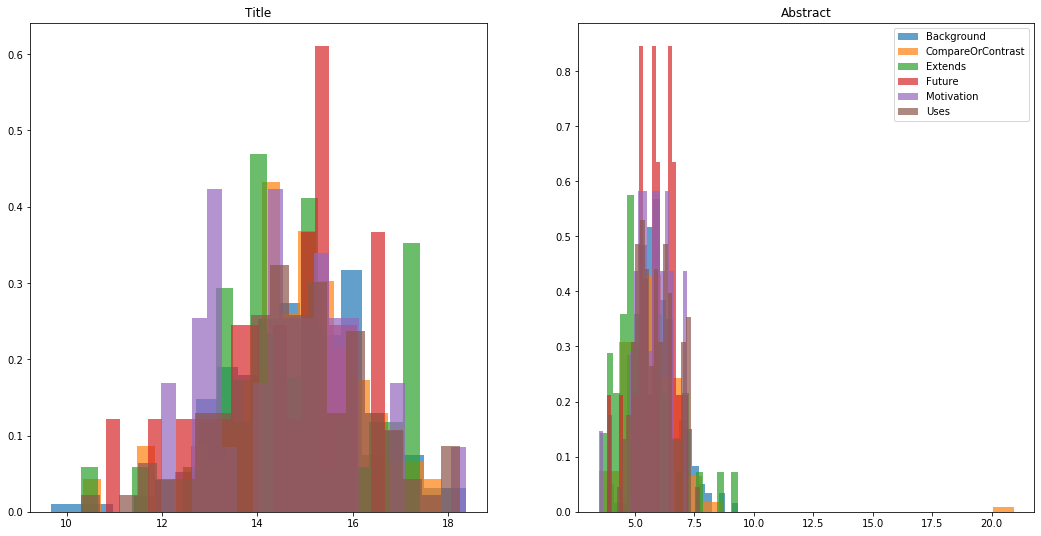

In [14]:
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.title('Title')
for key, value in title_diff_norm_dict.items():
    if key != 'not sure':
        plt.hist(value, bins=20, alpha=0.7, label=key, density=True)

plt.subplot(1, 2, 2)
plt.title('Abstract')
for key, value in abstract_diff_norm_dict.items():
    if key != 'not sure':
        plt.hist(value, bins=20, alpha=0.7, label=key, density=True)

plt.legend()
plt.show()